# Makine Öğrenmesi

## 2. Doğrusal Olmayan Regresyon

Doğrusal olmayan regresyon, istatistik bilimde gözlemi yapılan verilerin bir veya birden fazla bağımsız değişkenin model parametrelerinin doğrusal olmayan bileşiği olan ve bir veya daha çok sayıda bağımsız değişken ihtiva eden bir fonksiyonla modelleştirilmesini içeren bir regresyon (bağlanım) analizi türüdür. Veriler arka-arkaya yapılan yaklaşımlarla kurulan modele uydurularak çözümleme yapılır.

Bu başlıkta incelenecek Doğrusal Olmayan Regresyon yöntemleri:

    K En Yakın Komşu (KNN)
    Destek Vektör Regresyonu (SVR)
    Çok Katmanlı Algılayıcılar (ANN)
    Karar Ağaçları / Classification and Regression Trees (CART)
    Bagging (Bootstrap Aggregation)
    Random Forests (RF)
    Gradient Boosting Machines (GBM)
    Extreme Gradient Boosting (XGBoost)
    LightGBM
    CatBoost


In [61]:
!pip install skompiler
!pip install astor
!pip install xgboost
!pip install catboost
!pip install lightgbm
#conda install -c conda-forge lightgbm


In [4]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler


from skompiler import skompile
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMRegressor

from warnings import filterwarnings
filterwarnings('ignore')

from datetime import datetime

### 2.1. K En Yakın Komşu (KNN)
KNN en basit anlamı ile içerisinde tahmin edilecek değerin bağımsız değişkenlerinin oluşturduğu vektörün en yakın komşularının hangi sınıfta yoğun olduğu bilgisi üzerinden sınıfını tahmin etmeye dayanır.

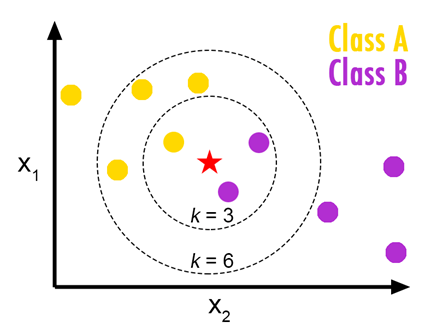

İşlem Adımları

    Komşu sayısını belirle (k)
    Bilinmeyen nokta ile diğer tüm noktalar arasındaki uzaklıkları hesapla
    Uzaklıkları sırala ve belirlenen k değerine göre en yakın k sayıda gözlemi seç
    Sınıflandırma yapılıyorsa en sık karşılaşılan sınıf, regresyon yapılıyor ise ortalama değeri tahmin değeri olarak belirle

#### 2.1.1. Model

In [20]:
help(KNeighborsRegressor)
?KNeighborsRegressor

Help on class KNeighborsRegressor in module sklearn.neighbors._regression:

class KNeighborsRegressor(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.RegressorMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Regression based on k-nearest neighbors.
 |  
 |  The target is predicted by local interpolation of the targets
 |  associated of the nearest neighbors in the training set.
 |  
 |  Read more in the :ref:`User Guide <regression>`.
 |  
 |  .. versionadded:: 0.9
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |      

In [13]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

knn_model = KNeighborsRegressor().fit(X_train, y_train)

In [14]:
knn_model

KNeighborsRegressor()

In [17]:
knn_model.n_neighbors #default değeri 5

5

In [23]:
knn_model.effective_metric_

'euclidean'

#### 2.1.2. Tahmin

In [24]:
y_pred = knn_model.predict(X_test)

print("test hatası:" , np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE = [] 
#cross validation yapmadan hatalara bir bakalim
for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    RMSE.append(rmse) 
    print("k =" , k , "için RMSE değeri: ", rmse)


test hatası: 421.6252180741266
k = 1 için RMSE değeri:  0.0
k = 2 için RMSE değeri:  179.52761335480352
k = 3 için RMSE değeri:  205.20157172291863
k = 4 için RMSE değeri:  220.5139794876305
k = 5 için RMSE değeri:  239.6467132541376
k = 6 için RMSE değeri:  243.5904190007242
k = 7 için RMSE değeri:  258.1478781634636
k = 8 için RMSE değeri:  266.05374203349805
k = 9 için RMSE değeri:  269.73782093553376
k = 10 için RMSE değeri:  271.2798300436963


#### 2.1.3. Model Tuning

In [34]:
#GridSearchCV ile optimum k sayisinin belirlenmesi
knn_params = {'n_neighbors': np.arange(1,30,1)}
knn = KNeighborsRegressor()
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10)
knn_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [29]:
knn_cv_model.best_params_["n_neighbors"]

8

In [35]:
RMSE = [] 
RMSE_CV = []
for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train) 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred)) 
    rmse_cv = np.sqrt(-1*cross_val_score(knn_model, X_train, y_train, cv=10, 
                                         scoring = "neg_mean_squared_error").mean())
    #cross validation olmadan hatalar
    RMSE.append(rmse) 
    #cross validation kullanilarak alindan hatalar
    RMSE_CV.append(rmse_cv)
    print("k =" , k , "için RMSE değeri: ", rmse, "RMSE_CV değeri: ", rmse_cv )


k = 1 için RMSE değeri:  0.0 RMSE_CV değeri:  325.3947514706382
k = 2 için RMSE değeri:  179.52761335480352 RMSE_CV değeri:  293.24000183333817
k = 3 için RMSE değeri:  205.20157172291863 RMSE_CV değeri:  283.7486667487823
k = 4 için RMSE değeri:  220.5139794876305 RMSE_CV değeri:  286.3240222024089
k = 5 için RMSE değeri:  239.6467132541376 RMSE_CV değeri:  290.0705466132226
k = 6 için RMSE değeri:  243.5904190007242 RMSE_CV değeri:  298.1263115575851
k = 7 için RMSE değeri:  258.1478781634636 RMSE_CV değeri:  294.77070479194987
k = 8 için RMSE değeri:  266.05374203349805 RMSE_CV değeri:  291.98672028891235
k = 9 için RMSE değeri:  269.73782093553376 RMSE_CV değeri:  295.7162739573105
k = 10 için RMSE değeri:  271.2798300436963 RMSE_CV değeri:  301.31047022701154


In [36]:
#k=2 için train degil test setini denediğimizde
knn_tuned = KNeighborsRegressor(n_neighbors =2)
knn_tuned.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, knn_tuned.predict(X_test)))

415.99629571490965

In [32]:
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_["n_neighbors"])
knn_tuned.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8)

In [33]:
np.sqrt(mean_squared_error(y_test, knn_tuned.predict(X_test)))

413.7094731463598

### 2.2. Destek Vektör Regresyonu (SVR)
Temel amaç, bir marjin aralığına maksimum noktayı en küçük hata ile alabilecek şekilde **doğru** ya da **eğrinin** belirlenmesidir.

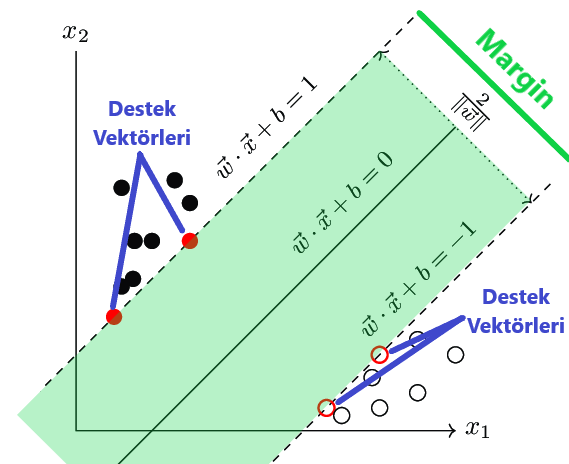



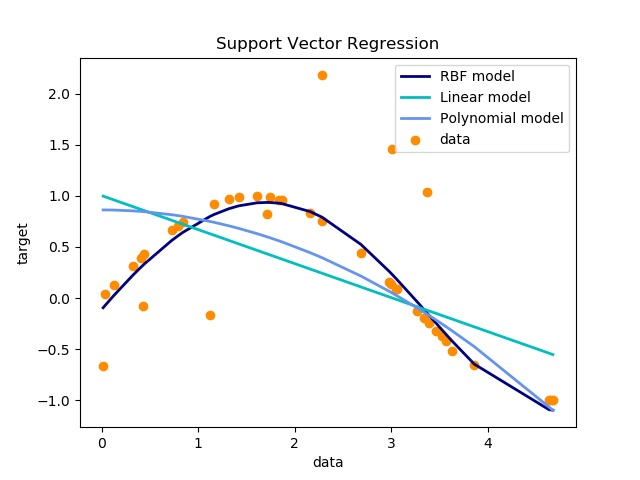

#### 2.2.1. Model (Doğrusal SVR)

In [144]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [145]:
#burada ornek olmasi acisindan sadece hits parametresi aliniyor ancak tum parametreleri de alabiliriz.
#model tuning altinda tum parametreler icin de deneyecegiz.
X_train = pd.DataFrame(X_train["Hits"])
X_test = pd.DataFrame(X_test["Hits"])
svr_model = LinearSVR().fit(X_train, y_train)

In [81]:
svr_model.predict(X_train)[0:5]
#ilk değer için modelimizi deneyebiliriz

array([416.25081147, 661.55370315, 698.58055472, 221.85984071,
       434.76423726])

In [82]:
#dogrusal modelimizin parametre katsayilari
print ("y = {0} + {1} x".format(svr_model.intercept_[0], 
                                svr_model.coef_[0])) 

y = -4.9296251787324845 + 4.628356446708846 x


In [83]:
X_train["Hits"][0:1]

183    91.0
Name: Hits, dtype: float64

In [85]:
#değerleri formulde yerine yazip sonucu aldigimizda dogru y degerine ulastigimizi goruyoruz. 
-4.9296251787324845 + 4.628356446708846*91

416.2508114717725

In [86]:
y_pred = svr_model.predict(X_train)

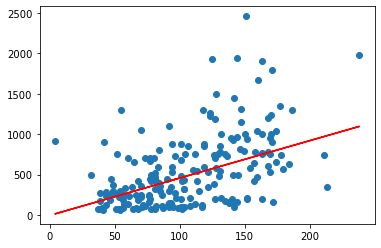

In [87]:
plt.scatter(X_train, y_train)
plt.plot(X_train,y_pred, color = "r")

In [92]:
#lineer regresyon modeliyle svm modelini karsilastiralim
lm_model = LinearRegression().fit(X_train, y_train)
lm_pred  = lm_model.predict(X_train)
print("y = {0} + {1} x".format(lm_model.intercept_, lm_model.coef_[0]))

y = -8.814095480334345 + 5.172456135470686 x


In [94]:
#lineer regresyon ile elde ettigimiz parametre katsayilari
-8.814095480334345 +5.172456135470686*91

461.87941284749803

Text(0, 0.5, 'Maaş (Salary)')

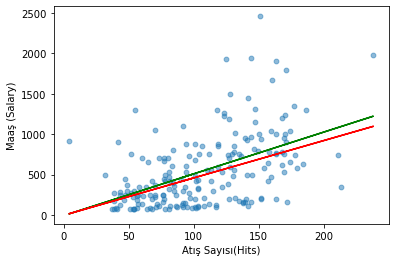

In [96]:
#iki yontemi de gorsel olarak karsilastiralim
plt.scatter(X_train, y_train, alpha=0.5, s=23)
plt.plot(X_train, lm_pred, 'g')
plt.plot(X_train, y_pred, color='r')

plt.xlabel("Atış Sayısı(Hits)")
plt.ylabel("Maaş (Salary)")

**Not:** Yukarıdaki grafik gözlemlendiğinde,

lineer regresyon yöntemiyle elde edilen doğru (yeşil) atış sayılarına göre daha fazla maaş verme eğilimindedir. bunun sebebi grafiğin üstünde görülen aykırı değerlerin lineer modelin tahminini yukarı çekmesidir.

SVR'de ise (robust bir yontem oldugundan) aykırı gözlemlerin etkisi daha düşüktür.

#### 2.2.2. Tahmin (Doğrusal SVR)

In [98]:
print ("y = {0} + {1} x".format(svr_model.intercept_[0], svr_model.coef_[0])) 

y = -4.9296251787324845 + 4.628356446708846 x


In [99]:
svr_model.predict([[91]])

array([416.25081147])

In [100]:
y_pred = svr_model.predict(X_test)

In [101]:
np.sqrt(mean_squared_error(y_test, y_pred))

454.99689593658314

#### 2.2.3. Model Tuning (Doğrusal SVR)

In [139]:
svr_params = {"C": np.arange(0.1,2,0.1)}
svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 10).fit(X_train,y_train)

In [140]:
pd.Series(svr_cv_model.best_params_)[0]

1.8000000000000003

In [141]:
svr_tuned = LinearSVR(C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, y_train)

In [142]:
y_pred = svr_tuned.predict(X_test)

In [143]:
np.sqrt(mean_squared_error(y_test, y_pred))

454.17324884908845

In [149]:
#svr modelin tum degiskenler icin calistirilmasi
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

svr_model = LinearSVR().fit(X_train, y_train)
svr_params = {"C": np.arange(0.1,2,0.1)}
svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 10).fit(X_train,y_train)

print(pd.Series(svr_cv_model.best_params_)[0])

svr_tuned = LinearSVR(C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, y_train)

y_pred = svr_tuned.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

0.5


393.7170093925675

In [154]:
svr_model.intercept_

array([1.01766865])

In [155]:
svr_model.coef_

array([-0.65070597,  2.55955374, -0.13651159,  0.54099385, -0.4352369 ,
        0.13310363,  2.7978767 , -0.09648882,  0.33266003,  0.72311014,
        0.68737114,  0.47901566,  0.25959701,  0.04147107,  0.04732602,
        0.46658634,  1.35220867,  0.05314158, -0.02485774])

#### 2.2.4. Model (Doğrusal Olmayan SVR)

In [169]:
#bir veriseti olusturup lineer regresyon ile SVR'yi gorsel olarak karsilastiralim
np.random.seed(3)

x_sim = np.random.uniform(2, 10, 145)
y_sim = np.sin(x_sim) + np.random.normal(0, 0.4, 145)
#aykırı gözlemler
x_outliers = np.arange(2.5, 5, 0.5)
y_outliers = -5*np.ones(5)

x_sim_idx = np.argsort(np.concatenate([x_sim, x_outliers]))
x_sim = np.concatenate([x_sim, x_outliers])[x_sim_idx]
y_sim = np.concatenate([y_sim, y_outliers])[x_sim_idx]

In [170]:
#lineer regresyon
ols = LinearRegression()
ols.fit(np.sin(x_sim[:, np.newaxis]), y_sim)
ols_pred = ols.predict(np.sin(x_sim[:, np.newaxis]))

#SVR
eps = 0.1 #default degeri
#rbf=radial bases function (dogrusal olmayan bir form)
svr = SVR(kernel='rbf', epsilon = eps)
svr.fit(x_sim[:, np.newaxis], y_sim)
svr_pred = svr.predict(x_sim[:, np.newaxis])

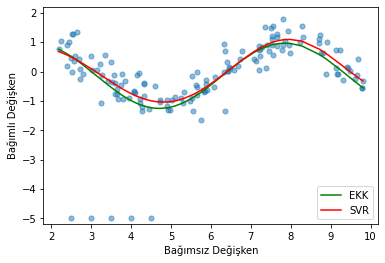

In [168]:
plt.scatter(x_sim, y_sim, alpha=0.5, s=26)
plt_ols, = plt.plot(x_sim, ols_pred, 'g')
plt_svr, = plt.plot(x_sim, svr_pred, color='r')
plt.xlabel("Bağımsız Değişken")
plt.ylabel("Bağımlı Değişken")
plt.ylim(-5.2, 2.2)
plt.legend([plt_ols, plt_svr], ['EKK', 'SVR'], loc = 4);

**Not:** Grafikte sol altta eklenen aykırı değerlere dikkat edin. onceki bolumde oldugu gibi En Kucuk  Kareler yontemini kullanan lineer regresyon yonteminin egrisini asagi cektigini gozlemleyebilirsiniz.

In [191]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [192]:
svr_rbf = SVR(kernel="rbf").fit(X_train, y_train)

#### 2.2.5. Tahmin (Doğrusal Olmayan SVR)

In [193]:
y_pred = svr_rbf.predict(X_test)

In [194]:
np.sqrt(mean_squared_error(y_test, y_pred))

460.0032657244849

#### 2.2.6. Model Tuning (Doğrusal Olmayan SVR)

In [205]:
svr_params = {"C": [0.01, 0.1,0.4,5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000]}
svr_cv_model = GridSearchCV(svr_rbf,svr_params, cv = 10)
svr_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 0.4, 5, 10, 20, 30, 40, 50, 60, 70,
                               80, 90, 100, 110, 120, 130, 140, 200, 300, 400,
                               500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, ...]})

In [206]:
svr_cv_model.best_params_

{'C': 3000}

In [207]:
svr_tuned = SVR(kernel="rbf", C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, 
                                                                        y_train)


In [208]:
y_pred = svr_tuned.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

380.814741255951

### 2.3. Çok Katmanlı Algılayıcı (Yapay Sinir Ağları YSA)
İnsan beyninin bilgiyi işleme şeklini referans alan sınıflandırma ve regresyon problemleri için kullanılabilen kuvvetli makine öğrenmesi algoritmalarından bir tanesidir.

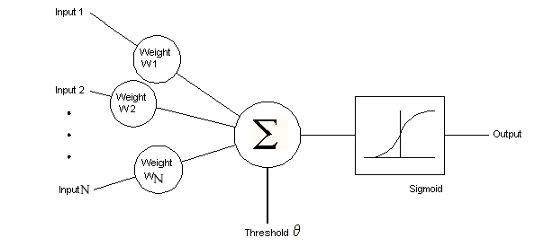

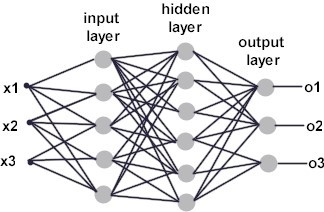

#### 2.3.1. Model

In [5]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [12]:
#değişken standartlaştırması
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
mlp_model = MLPRegressor(hidden_layer_sizes = (100,20)).fit(X_train_scaled, y_train)
print(mlp_model)
print(mlp_model.n_layers_)
print(mlp_model.hidden_layer_sizes)

MLPRegressor(hidden_layer_sizes=(100, 20))
4
(100, 20)


#### 2.3.2.Tahmin

In [17]:
y_pred = mlp_model.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test, y_pred))

467.13400473761504

#### 2.3.3. Model Tuning

In [18]:
mlp_model

MLPRegressor(hidden_layer_sizes=(100, 20))

In [19]:
mlp_params = {'alpha': [0.1, 0.01,0.02,0.005],
             'hidden_layer_sizes': [(20,20),(100,50,150),(300,200,150)],
             'activation': ['relu','logistic']}

In [21]:
mlp_cv_model = GridSearchCV(mlp_model, mlp_params, cv = 10)
mlp_cv_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=MLPRegressor(hidden_layer_sizes=(100, 20)),
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 0.02, 0.005],
                         'hidden_layer_sizes': [(20, 20), (100, 50, 150),
                                                (300, 200, 150)]})

In [36]:
mlp_cv_model.best_params_

'relu'

In [41]:
mlp_tuned = MLPRegressor(activation=mlp_cv_model.best_params_['activation'],
                         alpha = mlp_cv_model.best_params_['alpha'], 
                         hidden_layer_sizes = mlp_cv_model.best_params_['hidden_layer_sizes'])
print(mlp_tuned)
print(mlp_tuned.activation)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 50, 150))
relu


In [42]:
mlp_tuned.fit(X_train_scaled, y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 50, 150))

In [44]:
y_pred = mlp_tuned.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test, y_pred))

355.12402419080627

### 2.4. Karar Ağaçları / Classification and Regression Trees (CART)
Temel amaç veriseti içerisindeki karmaşık yapıları basit karar yapılarına dönüştürmektir.
Heterojen verisetleri belirlenmiş bir hedef değişkene göre homojen alt gruplara ayrılır.

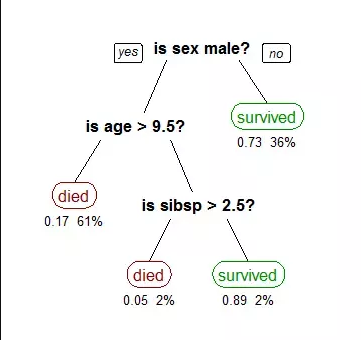


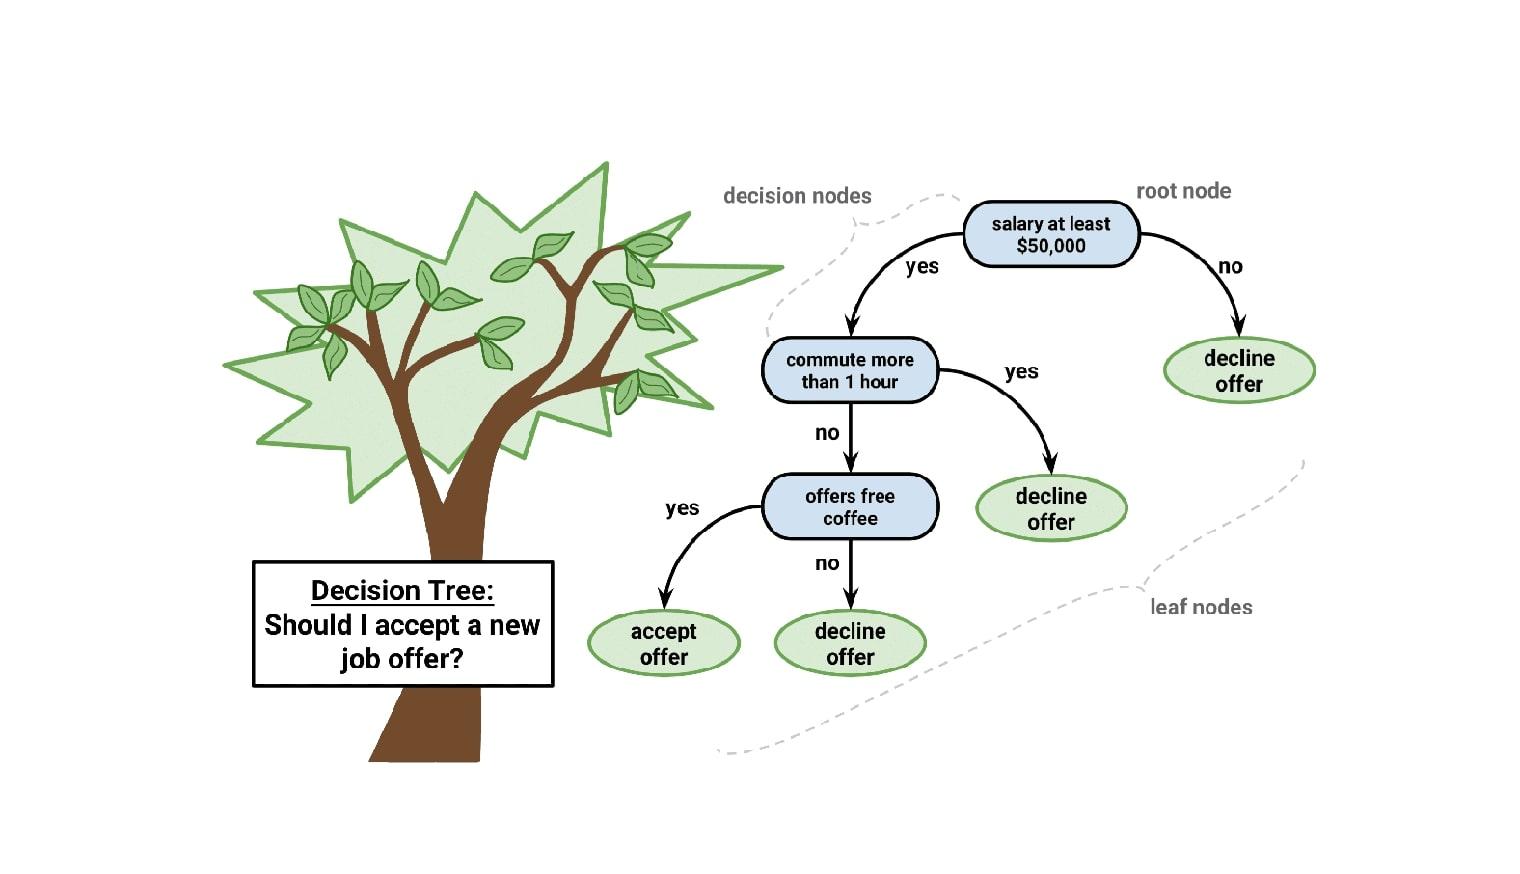

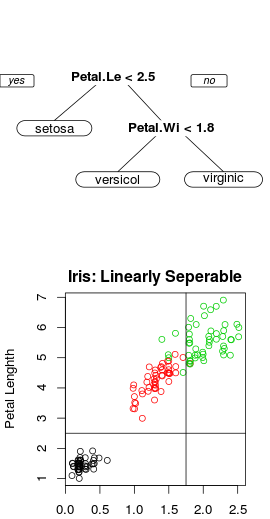

#### 2.4.1. Model

In [45]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [46]:
#tek bir bagimsiz degiskenle deneyelim
X_train = pd.DataFrame(X_train["Hits"])
X_test = pd.DataFrame(X_test["Hits"])

In [51]:
cart_model = DecisionTreeRegressor()
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

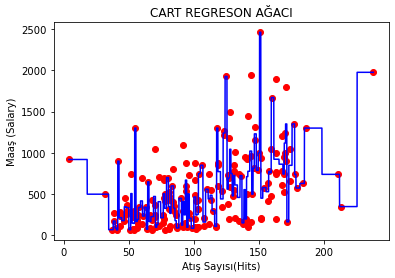

In [52]:
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01) 
X_grid = X_grid.reshape((len(X_grid), 1))  
plt.scatter(X_train, y_train, color = 'red') 
plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')  
plt.title('CART REGRESON AĞACI')  
plt.xlabel('Atış Sayısı(Hits)') 
plt.ylabel('Maaş (Salary)') ;

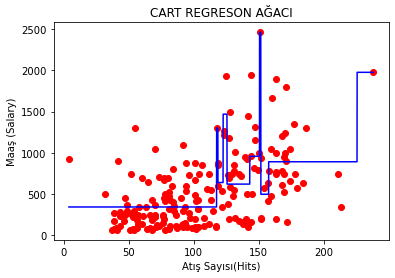

In [63]:
#farklı parametrelerle deneyelim
cart_model = DecisionTreeRegressor(max_leaf_nodes=10)
cart_model.fit(X_train, y_train)
X_grid = np.arange(min(np.array(X_train)),max(np.array(X_train)), 0.01) 
X_grid = X_grid.reshape((len(X_grid), 1))  
plt.scatter(X_train, y_train, color = 'red') 
plt.plot(X_grid, cart_model.predict(X_grid), color = 'blue')  
plt.title('CART REGRESON AĞACI')  
plt.xlabel('Atış Sayısı(Hits)') 
plt.ylabel('Maaş (Salary)') ;

In [65]:
#skompiler kutuphanesi ile karar agacinin karar modelini python koduna ceviriyoruz
print(skompile(cart_model.predict).to('python/code'))

(345.2011551724138 if x[0] <= 117.5 else ((((1300.0 if x[0] <= 118.5 else 
    641.0) if x[0] <= 122.5 else 1468.5236666666667) if x[0] <= 125.5 else 
    621.9679230769232) if x[0] <= 143.0 else (958.6111111111111 if x[0] <= 
    150.5 else 2460.0) if x[0] <= 151.5 else 499.1666666666667 if x[0] <= 
    157.5 else 892.5402413793104) if x[0] <= 225.5 else 1975.0)



#### 2.4.2. Tahmin

In [70]:
x = [91]

In [71]:
(345.2011551724138 if x[0] <= 117.5 else ((((1300.0 if x[0] <= 118.5 else 
    641.0) if x[0] <= 122.5 else 1468.5236666666667) if x[0] <= 125.5 else 
    621.9679230769232) if x[0] <= 143.0 else (958.6111111111111 if x[0] <= 
    150.5 else 2460.0) if x[0] <= 151.5 else 499.1666666666667 if x[0] <= 
    157.5 else 892.5402413793104) if x[0] <= 225.5 else 1975.0)

345.2011551724138

In [77]:
X_test[0:5]

,Hits
148,136.0
154,147.0
318,136.0
279,96.0
88,41.0


In [72]:
cart_model.predict(X_test)[0:5]

array([621.96792308, 958.61111111, 621.96792308, 345.20115517,
       345.20115517])

In [73]:
cart_model.predict([[91]])

array([345.20115517])

In [76]:
y_pred =cart_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

486.34593105235456

#### 2.4.3. Model Tuning

In [78]:
cart_model = DecisionTreeRegressor()
cart_model.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)

In [79]:
np.sqrt(mean_squared_error(y_test, y_pred))

468.49579052913884

In [80]:
cart_params = {"min_samples_split": range(2,100),
               "max_leaf_nodes": range(2,10)}

In [82]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10)
cart_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(2, 100)})

In [83]:
cart_cv_model.best_params_

{'max_leaf_nodes': 9, 'min_samples_split': 76}

In [84]:
cart_tuned = DecisionTreeRegressor(max_leaf_nodes = 9, min_samples_split = 76)

In [85]:
cart_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=9, min_samples_split=76)

In [86]:
y_pred = cart_tuned.predict(X_test)

In [87]:
np.sqrt(mean_squared_error(y_test, y_pred))

423.406689243066

In [90]:
#tum bagimsiz degiskenlerle tekrar deneyelim
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)
#ilkel test hatasina bir bakalim
cart_model = DecisionTreeRegressor()
cart_model.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

#cross validation
cart_params = {"min_samples_split": range(2,100),
               "max_leaf_nodes": range(2,10)}
cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10)
cart_cv_model.fit(X_train, y_train)
print(cart_cv_model.best_params_)
cart_tuned = DecisionTreeRegressor(max_leaf_nodes = cart_cv_model.best_params_['max_leaf_nodes'], 
                                   min_samples_split = cart_cv_model.best_params_['min_samples_split'])
cart_tuned.fit(X_train, y_train)
y_pred = cart_tuned.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

450.13204450170826
{'max_leaf_nodes': 9, 'min_samples_split': 37}
376.39788207109865


### 2.5. Bagged Trees Regresyon
Tameli, Boostrap yöntemi ile oluşturulan birden fazla karar ağacının ürettiği tahminlerin bir araya getirilerek değerlendirilmesine dayanır.

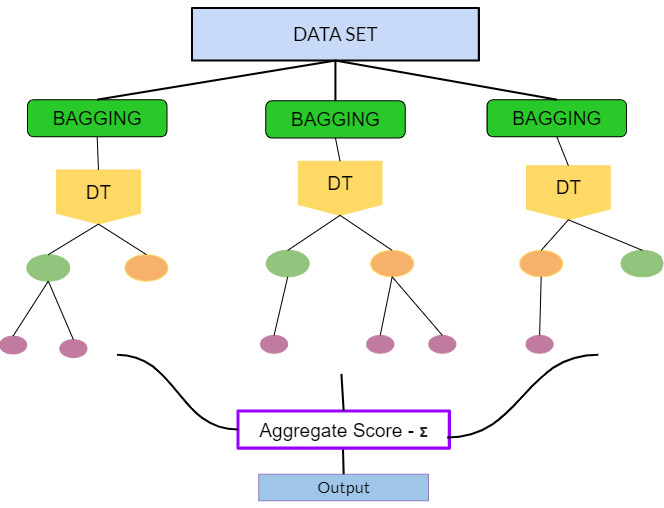

#### 2.5.1. Model

In [91]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [94]:
#bootstrap_features default degeri false, bootstrap orneklerini gozlemlemek icin true verdik
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [96]:
#tahminci sayisi
bag_model.n_estimators

10

In [97]:
#10 adet agac
bag_model.estimators_

[DecisionTreeRegressor(random_state=977253065),
 DecisionTreeRegressor(random_state=105505262),
 DecisionTreeRegressor(random_state=119123992),
 DecisionTreeRegressor(random_state=1014273599),
 DecisionTreeRegressor(random_state=1824248189),
 DecisionTreeRegressor(random_state=608451552),
 DecisionTreeRegressor(random_state=1543279080),
 DecisionTreeRegressor(random_state=203242740),
 DecisionTreeRegressor(random_state=1657249161),
 DecisionTreeRegressor(random_state=1153084323)]

In [98]:
#her bir agacin ornekleri
bag_model.estimators_samples_

[array([101,  58, 145, 121,  26, 192,  67, 155,  41, 116, 153, 181,  41,
        140,  32, 174, 171, 162, 122,  38,  81, 175, 172, 159, 136,  68,
        164,  32, 136,  50, 187,  28, 174,  28,  18,  77, 129,  22,  39,
        163,  10,  48,  88,  79,  64, 187,  91, 145, 111, 122,  87,  44,
         65,  95, 128,  23,  88,  57, 160, 156,  74, 181, 154, 128,  98,
        193, 157, 193,  73,   4, 146,  94, 134, 175,  61,  89, 145, 115,
         69,  27,  38, 173,  85,  68,  94,  83, 108, 186, 100, 127,  23,
         72,  64, 133,  20,   1,  10,   1,  13, 146,  83,  46,  49,  87,
         90, 126, 133,  10, 164,  68,  52,  29, 112,  49,  93, 132,  25,
        139, 165, 157,  39,  23,  36, 127,  52,   1, 154, 148,  44, 101,
         88,  49,  87,  16,  54, 167,  77,  32,  25,  11, 189, 134,  96,
         14, 135, 137, 104,  78,  27,  54, 111,  61, 119,  78,  41,  49,
         42, 182,  42,  96,  10, 119, 164,  97,  77, 195, 123,  52, 191,
        130,  46,   0, 180,  63, 133,  53,  34, 195

In [99]:
#her agacin bagimsiz degiskenleri
bag_model.estimators_features_

[array([ 9, 10, 17, 15, 11, 13, 10, 15,  8,  3,  1,  4, 15,  3,  3,  7, 13,
         1, 10]),
 array([14, 12,  0, 11,  4, 10,  3, 17,  3,  4, 17, 11,  8,  0,  2,  5, 18,
         4,  9]),
 array([ 8, 18,  2,  6, 13, 13, 12, 15,  0,  5,  3,  8, 12,  8,  6, 18,  2,
        17,  5]),
 array([10,  2,  6,  8,  9,  9, 13,  3,  9, 10, 10,  1, 14, 10, 10,  1, 10,
        16,  6]),
 array([ 8, 10, 17, 11, 17, 10,  8, 10, 14, 18, 12, 18, 12, 15, 13,  1, 12,
         5, 15]),
 array([ 0,  5, 16, 18,  4,  2, 15,  1, 12, 15, 11,  1,  5, 14, 10,  9, 13,
         3, 13]),
 array([ 8,  8, 14,  5,  5, 18, 15, 11,  8, 17, 16, 15,  9,  0,  0,  1, 14,
        18, 13]),
 array([18, 11,  3, 14, 16, 11,  7,  3, 15,  7, 15,  0, 18, 13, 16,  2, 16,
        16,  9]),
 array([ 9,  3, 17,  0, 11,  7,  7,  7,  0, 10,  5, 17,  2,  7,  1,  9,  8,
        18, 10]),
 array([ 3, 16, 13,  1, 14, 10,  6, 14,  4,  0,  4,  0,  4, 11,  6, 15, 12,
         8,  5])]

#### 2.5.2. Tahmin

In [102]:
y_pred = bag_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

367.57859357866835

In [104]:
iki_y_pred = bag_model.estimators_[1].fit(X_train, y_train).predict(X_test)

In [105]:
np.sqrt(mean_squared_error(y_test, iki_y_pred))

475.0748106579605

In [108]:
yedi_y_pred = bag_model.estimators_[6].fit(X_train, y_train).predict(X_test)

In [109]:
np.sqrt(mean_squared_error(y_test, yedi_y_pred))

473.3433313048018

#### 2.5.3. Model Tuning

In [110]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [111]:
bag_params = {"n_estimators": range(2,20)}

In [112]:
bag_cv_model = GridSearchCV(bag_model, bag_params, cv = 10)

In [113]:
bag_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
             param_grid={'n_estimators': range(2, 20)})

In [114]:
bag_cv_model.best_params_

{'n_estimators': 13}

In [115]:
bag_tuned = BaggingRegressor( n_estimators = 13, random_state = 45)

In [116]:
bag_tuned.fit(X_train, y_train)

BaggingRegressor(n_estimators=13, random_state=45)

In [117]:
y_pred = bag_tuned.predict(X_test)

In [118]:
np.sqrt(mean_squared_error(y_test, y_pred))

350.46489785227396

### 2.6. Random Forests
Temeli birden çok karar ağacının ürettiği tahminlerin bir araya getirilerek değerlendirilmesidir.

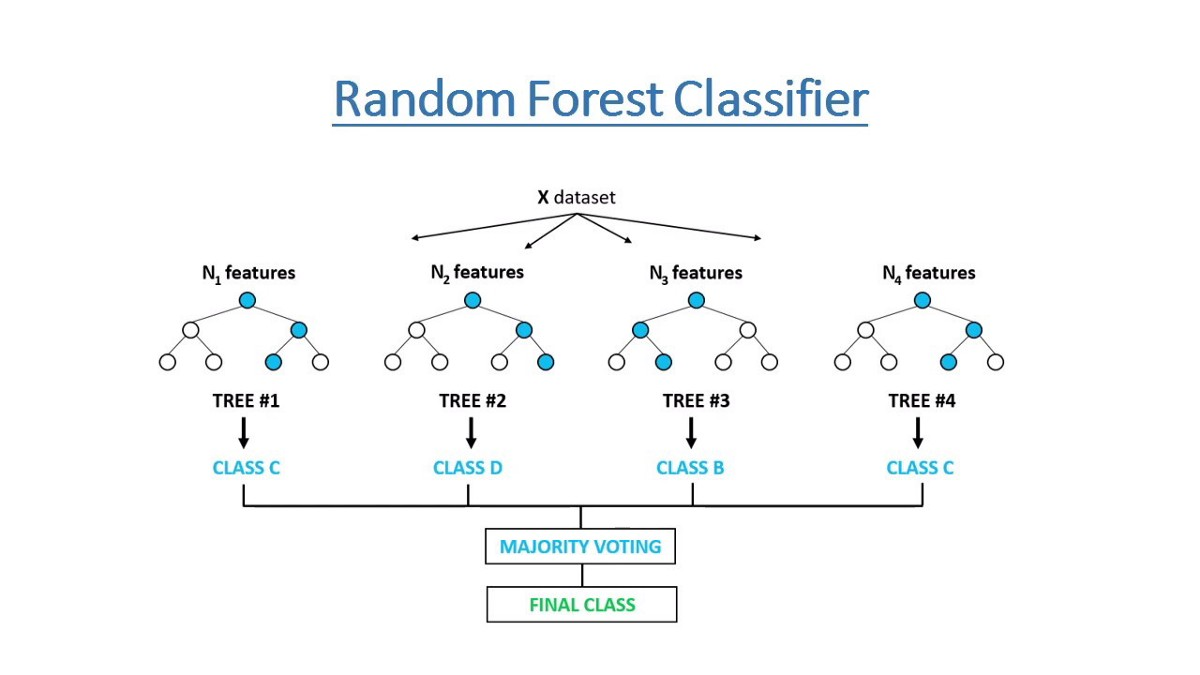

Bagging (Breiman, 1996) ile Random Subspace (Ho, 1998) yöntemlerinin birleşimi ile oluşmuştur. 

Ağaçlar için gözlemler bootstrap rastgele örnek seçim yöntemi ile değişkenler random subspace yöntemi ile seçilir. 

Karar ağacının her bir düğümünde en iyi dallara ayırıcı (bilgi kazancı) değişken tüm değişkenler arasından rastgele seçilen daha az sayıdaki değişken arasından seçilir. 

Ağaç oluşturmada veri setinin 2/3'ü kullanılır. Dışarıda kalan veri ağaçların performans değerlendirmesi ve değişken öneminin belirlenmesi için kullanılır. 

Her düğüm noktasında rastgele değişken seçimi yapılır. (regresyon'da p/3, sınıflama'da karekök p) 

Nihai tahmin için ağaçlardan tahmin değerleri talep edilirken her bir ağacın daha önce hesaplanan hata oranları göz önüne alınarak ağaçlara ağırlık verilir. 


#### 2.6.1. Model

In [123]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [124]:
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### 2.6.2. Tahmin

In [125]:
rf_model.predict(X_test)[0:5]

array([ 738.69167,  913.51164, 1181.145  ,  139.65167,  634.60833])

In [126]:
y_pred = rf_model.predict(X_test)

In [127]:
np.sqrt(mean_squared_error(y_test, y_pred))

344.8191624908484

#### 2.6.3. Model Tuning

In [131]:
rf_params = {'max_depth': list(range(1,10)),
            'max_features': [3,5,10,15],
            'n_estimators' : [100, 200, 500, 1000, 2000]}
rf_model = RandomForestRegressor(random_state = 42)
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                            n_jobs = -1)
# n_jobs = -1 yukarida yapılacak hesap sayisi her bir degerin kombinasyonu dusunuldugunde cok fazla olmaktadır.
#n_jobs parametresi islemcinin paralel yurutebilecegi islemleri ayni anda yurutmesini saglamaktadır.

In [130]:
rf_cv_model.fit(X_train, y_train)
rf_cv_model.best_params_

{'max_depth': 8, 'max_features': 3, 'n_estimators': 200}

In [132]:
rf_tuned = RandomForestRegressor(max_depth  = 8, 
                                 max_features = 3, 
                                 n_estimators =200)

In [133]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=3, n_estimators=200)

In [135]:
y_pred = rf_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

351.34521010260306

In [138]:
#degiskenlerin onem duzeyine bir bakalim.
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

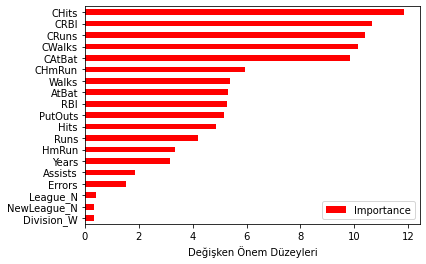

In [139]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

### 2.7. Gradient Boosting Machines (GBM)
AdaBoost'un sınıflandırma ve regresyon problemlerine kolayca uyarlanabilen genellenmiş bir versiyonudur.

Adaptive Boosting (AdaBoost) zayıf sınıflandırıcıların bir araya gelerek güçlü bir sınıflandırıcı oluşturması için geliştirilen bir yöntemdir.

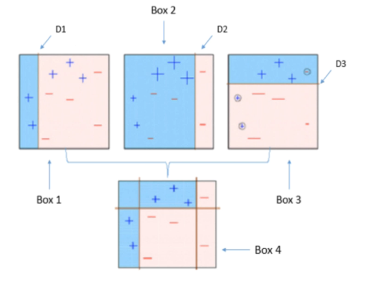


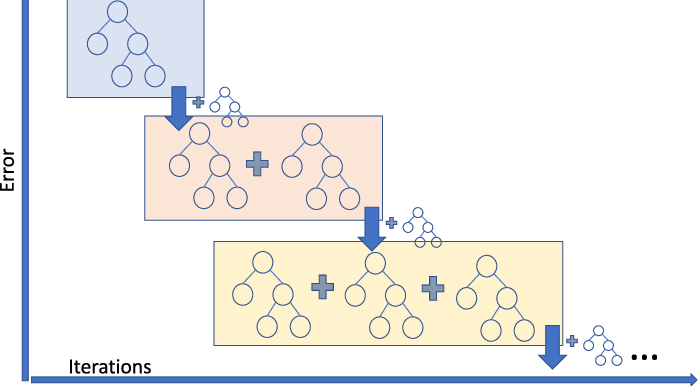

• Gradient boosting tek bir tahminsel model formunda olan modeller serisi oluşturur. 

• Seri içerisindeki bir model serideki bir önceki modelin tahmin artıklarının/ hatalarının (residuals) üzerine kurularak (fit) oluşturulur. 

• GBM diferansiyellenebilen herhangi bir kayıp fonksiyonunu optimize edebilen Gradient descent algoritmasını kullanmaktadır. 

• GB bir çok temel öğrenici tipi (base learner type) kullanabilir. (Trees, linear terms, splines,...) 

• Cost fonksiyonları ve link fonksiyonları modifiye edilebilirdir. 

• Boosting + Gradient Descent 


#### 2.7.1. Model

In [141]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [142]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

#### 2.7.2. Tahmin

In [143]:
y_pred = gbm_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

354.1575578077428

#### 2.7.3. Model Tuning

In [160]:
gbm_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 8,50,100],
    'n_estimators': [200, 500, 1000, 2000],
    'subsample': [1,0.5,0.75],
}

In [161]:
#algoritmanın calisma zamanina da bir bakalim
t1 =  datetime.now()
gbm = GradientBoostingRegressor()
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)
gbm_cv_model.fit(X_train, y_train)

t2 =  datetime.now()
print(t2-t1)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
0:05:42.135952


In [162]:
gbm_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 100, 'n_estimators': 200, 'subsample': 0.5}

In [163]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.1,  
                                      max_depth = 100, 
                                      n_estimators = 200, 
                                      subsample = 0.5)

gbm_tuned = gbm_tuned.fit(X_train,y_train)

In [164]:
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

353.32612601511073

In [165]:
Importance = pd.DataFrame({"Importance": gbm_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

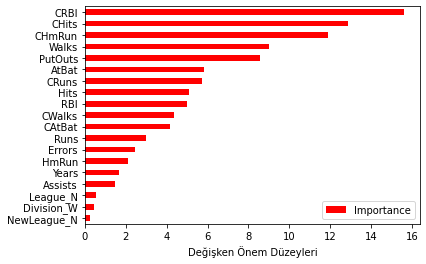

In [166]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

### 2.8. XGBoost (eXtreme Gradient Boosting)
XGBoost, GBM'in hız ve tahmin performansını arttırmak üzere optimize edilmiş; ölçeklenebilir ve farklı platformlara entegre edilebilir halidir.
    
    R, Python, Hadoop, Scala, Julia ile kullanılabilir
    Ölçeklenebilir
    Hızlı
    Tahmin başarısı yüksek
    Birçok kaggle yarışmasında başarısını kanıtlamış.

#### 2.8.1 Model

In [169]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [175]:
#pandas ya da numpy yerine kendi dataframeini kullanırsaniz daha performanslı calıstigi soylenmis.
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)

In [178]:
#pandas dataframei ile de kullanılabilir.
xgb_model = XGBRegressor().fit(X_train, y_train)

#### 2.8.2. Tahmin

In [179]:
y_pred = xgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

355.46515176059927

#### 2.8.3. Model Tuning

In [180]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [181]:
xgb_grid = {
     'colsample_bytree': [0.4, 0.5,0.6,0.9,1], 
     'n_estimators':[100, 200, 500, 1000],
     'max_depth': [2,3,4,5,6],
     'learning_rate': [0.1, 0.01, 0.5]
}


In [182]:
t1 =  datetime.now()

xgb = XGBRegressor()
xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid, 
                      cv = 10, 
                      n_jobs = -1,
                      verbose = 2)

xgb_cv.fit(X_train, y_train)

t2 =  datetime.now()
print(t2-t1)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
0:03:05.240480


In [183]:
xgb_cv.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 500}

In [184]:
xgb_tuned = XGBRegressor(colsample_bytree = 0.5, 
                         learning_rate = 0.1, 
                         max_depth = 2, 
                         n_estimators = 500) 

xgb_tuned = xgb_tuned.fit(X_train,y_train)

In [185]:
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

346.0275204366939

### 2.9. Light GBM
Light GBM, XGBoost'un eğitim süresini azaltmaya yönelik geliştirilmiş bir diğer GBM türüdür.

2017 yılında Microsoft tarafından geliştirilmiştir.

    Daha performanslıdır.
    Level-wise büyüme stratejisi yerine Leaf-wise büyüme stratejisi kullanır.
    Breadth-first search (BSF) yerine depth-first search (DFS) arama algoritmasını kullanır.

#### 2.9.1. Model

In [188]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [189]:
lgbm = LGBMRegressor()
lgbm_model = lgbm.fit(X_train, y_train)

#### 2.9.2. Tahmin

In [190]:
y_pred = lgbm_model.predict(X_test, 
                            num_iteration = lgbm_model.best_iteration_)

In [191]:
np.sqrt(mean_squared_error(y_test, y_pred))

363.8712087611089

#### 2.9.3. Model Tuning

In [192]:
lgbm_model

LGBMRegressor()

In [194]:
lgbm_grid = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [20, 40, 100, 200, 500,1000],
    'max_depth': [1,2,3,4,5,6,7,8] }

lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv=10, n_jobs = -1, verbose = 2)

In [195]:
t1 =  datetime.now()
lgbm_cv_model.fit(X_train, y_train)
t2 =  datetime.now()
print(t2-t1)

Fitting 10 folds for each of 960 candidates, totalling 9600 fits
0:01:32.304172


In [196]:
lgbm_cv_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 20}

In [197]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.1, 
                           max_depth = 6, 
                           n_estimators = 20,
                          colsample_bytree = 0.5)

lgbm_tuned = lgbm_tuned.fit(X_train,y_train)

In [198]:
y_pred = lgbm_tuned.predict(X_test)

In [199]:
np.sqrt(mean_squared_error(y_test, y_pred))

375.6085209015434

### 2.10. CatBoost

Kategorik değişkenler ile otomatik olarak ücadele edebilen, hızlı, başarılı bir diğer GBM türevidir.
2017 yılında Yandex tarafından geliştirilmiştir.

    Kategorik değişken desteği vardır.
    Hızlı ve ölçeklenebilir GPU desteği vardır.
    Hızlı train ve hızlı tahmin yapar
    


#### 2.10.1. Model

In [200]:
hit = pd.read_csv("data/Hitters.csv")
df = hit.copy()
df = df.dropna()
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [201]:
catb = CatBoostRegressor()
catb_model = catb.fit(X_train, y_train)

Learning rate set to 0.031674
0:	learn: 437.6430699	total: 175ms	remaining: 2m 54s
1:	learn: 431.3923642	total: 178ms	remaining: 1m 28s
2:	learn: 424.8820360	total: 184ms	remaining: 1m 1s
3:	learn: 418.2514904	total: 187ms	remaining: 46.6s
4:	learn: 412.6394021	total: 189ms	remaining: 37.6s
5:	learn: 406.6247020	total: 190ms	remaining: 31.5s
6:	learn: 400.5321206	total: 191ms	remaining: 27.1s
7:	learn: 394.6683437	total: 193ms	remaining: 23.9s
8:	learn: 388.2496484	total: 194ms	remaining: 21.4s
9:	learn: 382.9448842	total: 195ms	remaining: 19.3s
10:	learn: 377.2600080	total: 199ms	remaining: 17.9s
11:	learn: 372.4829606	total: 201ms	remaining: 16.5s
12:	learn: 366.6823437	total: 202ms	remaining: 15.4s
13:	learn: 362.6076230	total: 204ms	remaining: 14.3s
14:	learn: 358.0107745	total: 205ms	remaining: 13.4s
15:	learn: 353.2802665	total: 206ms	remaining: 12.7s
16:	learn: 348.5646265	total: 207ms	remaining: 12s
17:	learn: 343.6407912	total: 208ms	remaining: 11.4s
18:	learn: 339.2363847	tot

239:	learn: 112.2315070	total: 516ms	remaining: 1.63s
240:	learn: 111.9507125	total: 517ms	remaining: 1.63s
241:	learn: 111.7384492	total: 519ms	remaining: 1.62s
242:	learn: 111.0693763	total: 520ms	remaining: 1.62s
243:	learn: 110.3499926	total: 521ms	remaining: 1.61s
244:	learn: 110.2316231	total: 523ms	remaining: 1.61s
245:	learn: 109.6985998	total: 524ms	remaining: 1.6s
246:	learn: 109.4279824	total: 525ms	remaining: 1.6s
247:	learn: 109.1466762	total: 526ms	remaining: 1.59s
248:	learn: 108.9628542	total: 528ms	remaining: 1.59s
249:	learn: 108.7268676	total: 529ms	remaining: 1.59s
250:	learn: 108.0921190	total: 531ms	remaining: 1.58s
251:	learn: 107.6167844	total: 532ms	remaining: 1.58s
252:	learn: 106.9716563	total: 533ms	remaining: 1.57s
253:	learn: 106.4272485	total: 535ms	remaining: 1.57s
254:	learn: 106.2032614	total: 536ms	remaining: 1.56s
255:	learn: 105.5756794	total: 538ms	remaining: 1.56s
256:	learn: 105.4918649	total: 540ms	remaining: 1.56s
257:	learn: 105.2466976	total:

496:	learn: 49.6217364	total: 855ms	remaining: 865ms
497:	learn: 49.5268562	total: 856ms	remaining: 863ms
498:	learn: 49.3078402	total: 858ms	remaining: 861ms
499:	learn: 49.2571676	total: 859ms	remaining: 859ms
500:	learn: 49.2173141	total: 862ms	remaining: 858ms
501:	learn: 48.9813103	total: 863ms	remaining: 857ms
502:	learn: 48.8304542	total: 865ms	remaining: 855ms
503:	learn: 48.7430936	total: 866ms	remaining: 853ms
504:	learn: 48.5493989	total: 868ms	remaining: 851ms
505:	learn: 48.5134839	total: 869ms	remaining: 848ms
506:	learn: 48.3516141	total: 871ms	remaining: 846ms
507:	learn: 48.0631542	total: 872ms	remaining: 845ms
508:	learn: 47.8591880	total: 873ms	remaining: 843ms
509:	learn: 47.7182444	total: 875ms	remaining: 841ms
510:	learn: 47.6301870	total: 877ms	remaining: 839ms
511:	learn: 47.4767324	total: 879ms	remaining: 838ms
512:	learn: 47.2822625	total: 881ms	remaining: 836ms
513:	learn: 47.1022658	total: 883ms	remaining: 834ms
514:	learn: 47.0536181	total: 884ms	remaining:

738:	learn: 23.3081022	total: 1.2s	remaining: 422ms
739:	learn: 23.2915892	total: 1.2s	remaining: 421ms
740:	learn: 23.2095735	total: 1.2s	remaining: 419ms
741:	learn: 23.1588315	total: 1.2s	remaining: 417ms
742:	learn: 23.1197993	total: 1.2s	remaining: 415ms
743:	learn: 23.0327780	total: 1.2s	remaining: 413ms
744:	learn: 22.9759480	total: 1.2s	remaining: 412ms
745:	learn: 22.8751423	total: 1.2s	remaining: 410ms
746:	learn: 22.7768127	total: 1.21s	remaining: 408ms
747:	learn: 22.6474970	total: 1.21s	remaining: 407ms
748:	learn: 22.5780525	total: 1.21s	remaining: 405ms
749:	learn: 22.5338308	total: 1.21s	remaining: 403ms
750:	learn: 22.4330276	total: 1.21s	remaining: 402ms
751:	learn: 22.4193891	total: 1.21s	remaining: 400ms
752:	learn: 22.4093040	total: 1.21s	remaining: 398ms
753:	learn: 22.3758979	total: 1.22s	remaining: 397ms
754:	learn: 22.3560173	total: 1.22s	remaining: 395ms
755:	learn: 22.3264261	total: 1.22s	remaining: 393ms
756:	learn: 22.2796605	total: 1.22s	remaining: 391ms
7

986:	learn: 11.8870660	total: 1.53s	remaining: 20.2ms
987:	learn: 11.8411099	total: 1.54s	remaining: 18.7ms
988:	learn: 11.7973602	total: 1.54s	remaining: 17.1ms
989:	learn: 11.7514376	total: 1.54s	remaining: 15.6ms
990:	learn: 11.7232746	total: 1.54s	remaining: 14ms
991:	learn: 11.6852796	total: 1.54s	remaining: 12.4ms
992:	learn: 11.6463794	total: 1.54s	remaining: 10.9ms
993:	learn: 11.6106308	total: 1.54s	remaining: 9.33ms
994:	learn: 11.5731961	total: 1.55s	remaining: 7.77ms
995:	learn: 11.5417359	total: 1.55s	remaining: 6.22ms
996:	learn: 11.5167117	total: 1.55s	remaining: 4.66ms
997:	learn: 11.4745232	total: 1.55s	remaining: 3.11ms
998:	learn: 11.4604481	total: 1.55s	remaining: 1.55ms
999:	learn: 11.4510502	total: 1.55s	remaining: 0us


### 2.10.2. Tahmin

In [202]:
y_pred = catb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

351.194631344607

#### 2.10.3. Model Tuning

In [205]:
catb_grid = {
    'iterations': [200,500,1000,2000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [3,4,5,6,7,8] }

In [206]:
catb = CatBoostRegressor()
catb_cv_model = GridSearchCV(catb, catb_grid, cv=5, n_jobs = -1, verbose = 2)

In [207]:
t1 =  datetime.now()
catb_cv_model.fit(X_train, y_train)
t2 =  datetime.now()
print(t2-t1)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
0:	learn: 422.4143448	total: 10.7ms	remaining: 10.7s
1:	learn: 404.1864276	total: 11.9ms	remaining: 5.91s
2:	learn: 386.3231718	total: 12.9ms	remaining: 4.28s
3:	learn: 370.5548032	total: 14ms	remaining: 3.48s
4:	learn: 354.9242038	total: 14.9ms	remaining: 2.97s
5:	learn: 342.3403984	total: 15.9ms	remaining: 2.63s
6:	learn: 328.2370070	total: 16.9ms	remaining: 2.39s
7:	learn: 317.5056526	total: 17.8ms	remaining: 2.21s
8:	learn: 306.6243511	total: 18.7ms	remaining: 2.06s
9:	learn: 297.3147023	total: 19.9ms	remaining: 1.97s
10:	learn: 288.3685892	total: 20.9ms	remaining: 1.88s
11:	learn: 281.0996220	total: 21.9ms	remaining: 1.8s
12:	learn: 273.2254898	total: 22.8ms	remaining: 1.73s
13:	learn: 266.9003385	total: 24ms	remaining: 1.69s
14:	learn: 261.9092500	total: 25.2ms	remaining: 1.65s
15:	learn: 256.2637350	total: 26.2ms	remaining: 1.61s
16:	learn: 250.3667935	total: 27.2ms	remaining: 1.57s
17:	learn: 244.8631098	total: 28.3m

166:	learn: 56.8338370	total: 174ms	remaining: 866ms
167:	learn: 56.5518049	total: 175ms	remaining: 865ms
168:	learn: 55.9777349	total: 176ms	remaining: 865ms
169:	learn: 55.4485860	total: 177ms	remaining: 864ms
170:	learn: 55.0892542	total: 178ms	remaining: 862ms
171:	learn: 54.9915464	total: 179ms	remaining: 860ms
172:	learn: 54.3968112	total: 180ms	remaining: 858ms
173:	learn: 53.7708163	total: 180ms	remaining: 856ms
174:	learn: 53.1993023	total: 181ms	remaining: 855ms
175:	learn: 52.7773821	total: 182ms	remaining: 852ms
176:	learn: 52.5186612	total: 183ms	remaining: 851ms
177:	learn: 52.0038075	total: 184ms	remaining: 851ms
178:	learn: 51.7971195	total: 185ms	remaining: 850ms
179:	learn: 51.4334863	total: 186ms	remaining: 849ms
180:	learn: 50.9151359	total: 187ms	remaining: 847ms
181:	learn: 50.8252320	total: 188ms	remaining: 845ms
182:	learn: 50.4143487	total: 189ms	remaining: 844ms
183:	learn: 50.0253432	total: 190ms	remaining: 842ms
184:	learn: 49.6769233	total: 192ms	remaining:

331:	learn: 17.2732138	total: 338ms	remaining: 679ms
332:	learn: 17.1284244	total: 339ms	remaining: 678ms
333:	learn: 17.0578788	total: 340ms	remaining: 677ms
334:	learn: 16.9109643	total: 340ms	remaining: 676ms
335:	learn: 16.6595095	total: 341ms	remaining: 674ms
336:	learn: 16.5240861	total: 342ms	remaining: 673ms
337:	learn: 16.3631551	total: 343ms	remaining: 672ms
338:	learn: 16.2364521	total: 344ms	remaining: 670ms
339:	learn: 16.1259236	total: 345ms	remaining: 669ms
340:	learn: 16.1070160	total: 346ms	remaining: 668ms
341:	learn: 15.9446333	total: 346ms	remaining: 666ms
342:	learn: 15.8404109	total: 347ms	remaining: 665ms
343:	learn: 15.7616719	total: 348ms	remaining: 664ms
344:	learn: 15.7046860	total: 349ms	remaining: 662ms
345:	learn: 15.5565531	total: 350ms	remaining: 661ms
346:	learn: 15.4739767	total: 351ms	remaining: 660ms
347:	learn: 15.4214691	total: 352ms	remaining: 659ms
348:	learn: 15.3830392	total: 353ms	remaining: 658ms
349:	learn: 15.2925503	total: 353ms	remaining:

517:	learn: 5.4236755	total: 503ms	remaining: 468ms
518:	learn: 5.3864207	total: 504ms	remaining: 467ms
519:	learn: 5.3533466	total: 505ms	remaining: 466ms
520:	learn: 5.3369921	total: 506ms	remaining: 466ms
521:	learn: 5.2560437	total: 507ms	remaining: 465ms
522:	learn: 5.2017840	total: 508ms	remaining: 464ms
523:	learn: 5.1755812	total: 509ms	remaining: 463ms
524:	learn: 5.1385832	total: 510ms	remaining: 462ms
525:	learn: 5.1335579	total: 511ms	remaining: 461ms
526:	learn: 5.0585358	total: 512ms	remaining: 460ms
527:	learn: 5.0021152	total: 513ms	remaining: 459ms
528:	learn: 4.9822398	total: 514ms	remaining: 458ms
529:	learn: 4.9752376	total: 515ms	remaining: 457ms
530:	learn: 4.9479232	total: 516ms	remaining: 456ms
531:	learn: 4.9271142	total: 517ms	remaining: 455ms
532:	learn: 4.9023595	total: 518ms	remaining: 454ms
533:	learn: 4.8555527	total: 519ms	remaining: 453ms
534:	learn: 4.8367794	total: 520ms	remaining: 452ms
535:	learn: 4.7952444	total: 521ms	remaining: 451ms
536:	learn: 

695:	learn: 1.8711502	total: 670ms	remaining: 293ms
696:	learn: 1.8583228	total: 671ms	remaining: 292ms
697:	learn: 1.8482604	total: 672ms	remaining: 291ms
698:	learn: 1.8456936	total: 673ms	remaining: 290ms
699:	learn: 1.8273471	total: 674ms	remaining: 289ms
700:	learn: 1.8067825	total: 675ms	remaining: 288ms
701:	learn: 1.8022221	total: 676ms	remaining: 287ms
702:	learn: 1.7912070	total: 677ms	remaining: 286ms
703:	learn: 1.7755760	total: 678ms	remaining: 285ms
704:	learn: 1.7712682	total: 679ms	remaining: 284ms
705:	learn: 1.7648319	total: 680ms	remaining: 283ms
706:	learn: 1.7532904	total: 681ms	remaining: 282ms
707:	learn: 1.7463625	total: 682ms	remaining: 281ms
708:	learn: 1.7418161	total: 683ms	remaining: 280ms
709:	learn: 1.7272345	total: 684ms	remaining: 279ms
710:	learn: 1.7217505	total: 685ms	remaining: 278ms
711:	learn: 1.7151154	total: 685ms	remaining: 277ms
712:	learn: 1.7092925	total: 686ms	remaining: 276ms
713:	learn: 1.7025995	total: 687ms	remaining: 275ms
714:	learn: 

862:	learn: 0.6708199	total: 837ms	remaining: 133ms
863:	learn: 0.6689468	total: 838ms	remaining: 132ms
864:	learn: 0.6647579	total: 840ms	remaining: 131ms
865:	learn: 0.6587745	total: 841ms	remaining: 130ms
866:	learn: 0.6549437	total: 843ms	remaining: 129ms
867:	learn: 0.6484944	total: 844ms	remaining: 128ms
868:	learn: 0.6455316	total: 845ms	remaining: 127ms
869:	learn: 0.6420739	total: 846ms	remaining: 126ms
870:	learn: 0.6375667	total: 848ms	remaining: 126ms
871:	learn: 0.6358236	total: 849ms	remaining: 125ms
872:	learn: 0.6320335	total: 850ms	remaining: 124ms
873:	learn: 0.6288025	total: 851ms	remaining: 123ms
874:	learn: 0.6243292	total: 852ms	remaining: 122ms
875:	learn: 0.6165696	total: 854ms	remaining: 121ms
876:	learn: 0.6128782	total: 855ms	remaining: 120ms
877:	learn: 0.6057460	total: 856ms	remaining: 119ms
878:	learn: 0.6048833	total: 857ms	remaining: 118ms
879:	learn: 0.5984637	total: 858ms	remaining: 117ms
880:	learn: 0.5935168	total: 859ms	remaining: 116ms
881:	learn: 

In [208]:
catb_cv_model.best_params_

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.1}

In [209]:
catb_tuned = CatBoostRegressor(iterations = 1000, 
                               learning_rate = 0.1, 
                               depth = 5)

catb_tuned = catb_tuned.fit(X_train,y_train)

0:	learn: 422.4143448	total: 31.4ms	remaining: 31.3s
1:	learn: 404.1864276	total: 32.3ms	remaining: 16.1s
2:	learn: 386.3231718	total: 33.2ms	remaining: 11s
3:	learn: 370.5548032	total: 34ms	remaining: 8.46s
4:	learn: 354.9242038	total: 34.9ms	remaining: 6.93s
5:	learn: 342.3403984	total: 35.7ms	remaining: 5.92s
6:	learn: 328.2370070	total: 36.7ms	remaining: 5.2s
7:	learn: 317.5056526	total: 37.6ms	remaining: 4.66s
8:	learn: 306.6243511	total: 38.5ms	remaining: 4.24s
9:	learn: 297.3147023	total: 39.4ms	remaining: 3.9s
10:	learn: 288.3685892	total: 40.3ms	remaining: 3.62s
11:	learn: 281.0996220	total: 41.1ms	remaining: 3.38s
12:	learn: 273.2254898	total: 41.9ms	remaining: 3.18s
13:	learn: 266.9003385	total: 42.8ms	remaining: 3.01s
14:	learn: 261.9092500	total: 43.9ms	remaining: 2.88s
15:	learn: 256.2637350	total: 45ms	remaining: 2.77s
16:	learn: 250.3667935	total: 46.1ms	remaining: 2.67s
17:	learn: 244.8631098	total: 47ms	remaining: 2.56s
18:	learn: 240.1540669	total: 47.9ms	remaining: 

192:	learn: 46.9286959	total: 189ms	remaining: 790ms
193:	learn: 46.3092347	total: 190ms	remaining: 789ms
194:	learn: 45.7431428	total: 191ms	remaining: 788ms
195:	learn: 45.6714261	total: 192ms	remaining: 786ms
196:	learn: 45.5088158	total: 193ms	remaining: 785ms
197:	learn: 45.4713460	total: 193ms	remaining: 783ms
198:	learn: 45.0942536	total: 194ms	remaining: 782ms
199:	learn: 44.7625600	total: 195ms	remaining: 780ms
200:	learn: 44.3247006	total: 196ms	remaining: 779ms
201:	learn: 43.8054974	total: 197ms	remaining: 777ms
202:	learn: 43.3359785	total: 198ms	remaining: 776ms
203:	learn: 42.8698272	total: 198ms	remaining: 774ms
204:	learn: 42.4275364	total: 199ms	remaining: 773ms
205:	learn: 41.9463597	total: 200ms	remaining: 771ms
206:	learn: 41.7547985	total: 201ms	remaining: 770ms
207:	learn: 41.6019714	total: 202ms	remaining: 769ms
208:	learn: 41.4342896	total: 203ms	remaining: 767ms
209:	learn: 41.0764993	total: 204ms	remaining: 766ms
210:	learn: 40.7895715	total: 204ms	remaining:

391:	learn: 11.6241305	total: 357ms	remaining: 553ms
392:	learn: 11.5960420	total: 358ms	remaining: 552ms
393:	learn: 11.5729987	total: 358ms	remaining: 551ms
394:	learn: 11.5635235	total: 359ms	remaining: 550ms
395:	learn: 11.4873129	total: 360ms	remaining: 549ms
396:	learn: 11.3564378	total: 361ms	remaining: 548ms
397:	learn: 11.2078876	total: 362ms	remaining: 547ms
398:	learn: 11.1598904	total: 363ms	remaining: 546ms
399:	learn: 11.0885074	total: 364ms	remaining: 545ms
400:	learn: 11.0278575	total: 364ms	remaining: 544ms
401:	learn: 10.9865756	total: 365ms	remaining: 543ms
402:	learn: 10.8794931	total: 366ms	remaining: 542ms
403:	learn: 10.8382558	total: 367ms	remaining: 541ms
404:	learn: 10.7596014	total: 368ms	remaining: 541ms
405:	learn: 10.7064165	total: 369ms	remaining: 540ms
406:	learn: 10.6372130	total: 370ms	remaining: 539ms
407:	learn: 10.5505037	total: 371ms	remaining: 538ms
408:	learn: 10.4676489	total: 371ms	remaining: 537ms
409:	learn: 10.3632792	total: 372ms	remaining:

594:	learn: 3.3764192	total: 525ms	remaining: 357ms
595:	learn: 3.3590522	total: 526ms	remaining: 356ms
596:	learn: 3.3474857	total: 527ms	remaining: 356ms
597:	learn: 3.3123623	total: 528ms	remaining: 355ms
598:	learn: 3.2999589	total: 528ms	remaining: 354ms
599:	learn: 3.2767538	total: 529ms	remaining: 353ms
600:	learn: 3.2530783	total: 530ms	remaining: 352ms
601:	learn: 3.2269777	total: 531ms	remaining: 351ms
602:	learn: 3.1938868	total: 532ms	remaining: 350ms
603:	learn: 3.1728589	total: 533ms	remaining: 349ms
604:	learn: 3.1549029	total: 534ms	remaining: 348ms
605:	learn: 3.1478118	total: 534ms	remaining: 347ms
606:	learn: 3.1145245	total: 535ms	remaining: 347ms
607:	learn: 3.0718905	total: 536ms	remaining: 346ms
608:	learn: 3.0352714	total: 537ms	remaining: 345ms
609:	learn: 2.9984985	total: 538ms	remaining: 344ms
610:	learn: 2.9594115	total: 539ms	remaining: 343ms
611:	learn: 2.9438145	total: 540ms	remaining: 342ms
612:	learn: 2.9265773	total: 540ms	remaining: 341ms
613:	learn: 

799:	learn: 0.9867329	total: 694ms	remaining: 173ms
800:	learn: 0.9819829	total: 695ms	remaining: 173ms
801:	learn: 0.9777514	total: 696ms	remaining: 172ms
802:	learn: 0.9757462	total: 697ms	remaining: 171ms
803:	learn: 0.9702440	total: 697ms	remaining: 170ms
804:	learn: 0.9636471	total: 698ms	remaining: 169ms
805:	learn: 0.9548362	total: 699ms	remaining: 168ms
806:	learn: 0.9470745	total: 700ms	remaining: 167ms
807:	learn: 0.9408578	total: 701ms	remaining: 167ms
808:	learn: 0.9350692	total: 702ms	remaining: 166ms
809:	learn: 0.9290967	total: 703ms	remaining: 165ms
810:	learn: 0.9267158	total: 703ms	remaining: 164ms
811:	learn: 0.9235794	total: 704ms	remaining: 163ms
812:	learn: 0.9226084	total: 705ms	remaining: 162ms
813:	learn: 0.9139012	total: 706ms	remaining: 161ms
814:	learn: 0.9073690	total: 707ms	remaining: 160ms
815:	learn: 0.9024018	total: 708ms	remaining: 160ms
816:	learn: 0.9001693	total: 709ms	remaining: 159ms
817:	learn: 0.8970481	total: 710ms	remaining: 158ms
818:	learn: 

999:	learn: 0.2971131	total: 861ms	remaining: 0us


In [210]:
y_pred = catb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

356.665762904938